# Figure 6
This notebook recreates Figure 6 in Rein & Tamayo 2016. The figure illustrates the scaling of second order variational equations as a function of the number of varied parameters.

We start by import the REBOUND, numpy and matplotlib packages. 

In [29]:
import rebound
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from timeit import Timer
print(rebound.__build__)

Feb 15 2016 12:13:46


The following function initialises a simulation and adds a given number of variational parameters. It then runs the simulation for 100 time units.

In [30]:
def evaluate(order=0,N=0, integrator="ias15"):
    sim = rebound.Simulation()
    sim.integrator = integrator
    sim.add(m=1.)
    sim.add(primary=sim.particles[0],m=1e-3, a=1)
    sim.add(primary=sim.particles[0],m=1e-3, a=1.8,f=1.4)
    
    vs = ["a","e","i","omega","Omega","f","m"]
    var = []
    if order>=1:
        for i in range(N):
            pi = 1
            shifti = 0
            if i>=7:
                pi = 2
                shifti = -7
            var_d = sim.add_variation()
            var_d.vary(pi,vs[i+shifti])
            var.append(var_d)
        if order >=2:
            for i in range(N):
                pi = 1
                shifti = 0
                if i>=7:
                    pi = 2
                    shifti = -7
                for j in range(i,N):
                    pj = 1
                    shiftj = 0
                    if j>=7:
                        pj = 2
                        shiftj = -7
                    var_dd = sim.add_variation(order=2,first_order=var[i+shifti],first_order_2=var[j+shiftj])
                    if pi==pj:
                        var_dd.vary(pi,vs[i+shifti],vs[j+shiftj])
    
    sim.move_to_com()
    sim.integrate(100.)
             
    return 

Wrapper function to make `evaluate()` callable from a timer. 

In [26]:
def evaluateWithN(order,N,integrator="ias15"):
    def _e():
        evaluate(order,N,integrator)
        pass
    return _e

We now run the timing test for different numbers of parameters. 

In [31]:
Nmax = 15
repeat = 1
t = Timer(evaluateWithN(0,0))
var_0 = t.timeit(repeat*2)/2.
var_1 = np.zeros(Nmax)
var_2 = np.zeros(Nmax)
for i in range(Nmax):
    t = Timer(evaluateWithN(1,i))
    var_1[i] = t.timeit(repeat)
    t = Timer(evaluateWithN(2,i))
    var_2[i] = t.timeit(repeat)    

The following plot show the runtime of the simulation with variational equations compared to one without.

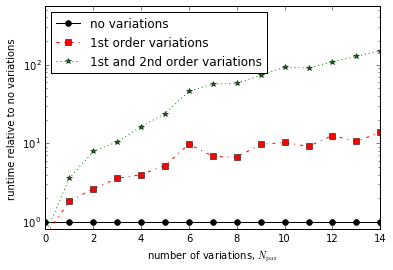

In [32]:
matplotlib.rcParams['legend.numpoints'] = 1
fig = plt.figure(figsize=(6,4))
ax = plt.subplot(111)
#ax.set_xlim(extent[0],extent[1])
ax.set_xlabel("number of variations, $N_{\\rm{par}}$")
ax.set_xlim(0,Nmax-1)
ax.set_ylim(0.8,550)
#ax.set_xscale("log")
ax.set_yscale("log")


ax.set_ylabel("runtime relative to no variations")
ax.plot(range(Nmax),np.ones(Nmax),"o-", color="black", label="no variations")
ax.plot(range(Nmax),var_1/var_0,"s-.", color="red", label="1st order variations")
ax.plot(range(Nmax),var_2/var_0,"*:", color="green", label="1st and 2nd order variations")

legend = plt.legend(loc=2)
ax = plt.gca().add_artist(legend)
plt.savefig('paper_test5.pdf',bbox_inches='tight')